#### Instruction (Read this)
- Use this template to develop your project. Do not change the steps. 
- For each step, you may add additional cells if needed.
- But remove <b>unnecessary</b> cells to ensure the notebook is readable.
- Marks will be <b>deducted</b> if the notebook is cluttered or difficult to follow due to excess or irrelevant content.
- <b>Briefly</b> describe the steps in the "Description:" field.
- <b>Do not</b> submit the dataset. 
- The submitted jupyter notebook will be executed using the uploaded dataset in eLearn.

#### Group Information

Group No: 

- Member 1: Teh Chun Shen (22303977)
- Member 2: Liew Zhe Xian (22305472)
- Member 3: Choo Yit Shern (22303762)
- Member 4: Yeap Jiong Ming (22301705)


#### Import libraries

In [16]:
# %config Completer.use_jedi=False # comment if not needed
import numpy as np
import pandas as pd

# split dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE

# data preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# feature selection
from sklearn.feature_selection import mutual_info_classif

# DT models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# SVM models
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

# Classification metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, precision_recall_curve

#### Load the dataset

In [18]:
# assume the dataset is in the same folder
dataset = pd.read_csv('seismic-bumps.csv')
dataset

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579,b,a,W,81410,785,432,151,b,0,0,0,0,0,0,0,0,0,0,0
2580,b,a,W,42110,555,213,118,a,0,0,0,0,0,0,0,0,0,0,0
2581,b,a,W,26960,540,101,112,a,0,0,0,0,0,0,0,0,0,0,0
2582,a,a,W,16130,322,2,2,a,0,0,0,0,0,0,0,0,0,0,0


#### Split the dataset
Split the dataset into training, validation and test sets.

In [20]:
# split the dataset into features and target
y = dataset['class']
x = dataset.drop(columns=['class'])

# 19 columns in total will turn into 18 after dropping the target column
print("Features: ", x.shape)
print("Target: ", y.shape)

Features:  (2584, 18)
Target:  (2584,)


In [21]:
# First, split into 80% (train + validation) and 20% (test)
X_temp, X_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# Then, split the 80% into 7/8 training and 1/8 validation
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=1/8, stratify=y_temp, random_state=42)

print("Training set: ", X_train.shape)
print("Validation set: ", X_valid.shape)
print("Test set: ", X_test.shape)

Training set:  (1808, 18)
Validation set:  (259, 18)
Test set:  (517, 18)


#### Data preprocessing
Perform data preprocessing such as normalization, standardization, label encoding etc.
______________________________________________________________________________________
Description:

Based on the data dictionary of the dataset, the attributes 'seismic', 'seismoacoustic' and 'ghazard' are listed with their possible values (“a – lack of hazard, b – low hazard, c – high hazard, d – danger state”). This project categorize those 3 attributes as ordinal categorical attributes because these labels represent increasing levels of assessed hazard. Ordinal Encoder is applied to convert them into numerical form and still maintaining the order of the values.

The 'shift' attribute labels each record by the type of work period, “W” for coal-getting versus “N” for preparation shift. This shows no implication that one shift is “higher” or “greater” than the other. Thus, we treat 'shift' attribute as a nominal categorical feature and apply a OneHotEncoder (with handle_unknown='ignore' to skip any new labels) and, since 'shift' is binary, drop one column to avoid collinearity (drop='if_binary').

The rest of the attributes such as 'genergy', 'gpuls' and nbumps are categorized as numerical attributes. Standard scaler is used for the numerical attributes because it centers features at zero mean and scales to unit variance, reducing outlier impact and preserving data structure, which allows model to learn more effectively.

In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   seismic         2584 non-null   object
 1   seismoacoustic  2584 non-null   object
 2   shift           2584 non-null   object
 3   genergy         2584 non-null   int64 
 4   gpuls           2584 non-null   int64 
 5   gdenergy        2584 non-null   int64 
 6   gdpuls          2584 non-null   int64 
 7   ghazard         2584 non-null   object
 8   nbumps          2584 non-null   int64 
 9   nbumps2         2584 non-null   int64 
 10  nbumps3         2584 non-null   int64 
 11  nbumps4         2584 non-null   int64 
 12  nbumps5         2584 non-null   int64 
 13  nbumps6         2584 non-null   int64 
 14  nbumps7         2584 non-null   int64 
 15  nbumps89        2584 non-null   int64 
 16  energy          2584 non-null   int64 
 17  maxenergy       2584 non-null   int64 
 18  class   

In [24]:
dataset.isnull().sum()

seismic           0
seismoacoustic    0
shift             0
genergy           0
gpuls             0
gdenergy          0
gdpuls            0
ghazard           0
nbumps            0
nbumps2           0
nbumps3           0
nbumps4           0
nbumps5           0
nbumps6           0
nbumps7           0
nbumps89          0
energy            0
maxenergy         0
class             0
dtype: int64

There are **no missing values** in this dataset. Thus, no measures are taken to handle missing values.

In [26]:
dataset['class'].value_counts()

class
0    2414
1     170
Name: count, dtype: int64

The dataset is **heavily skewed toward class “0”** which can bias the model toward the majority and yield deceptively high overall accuracy while consistently misclassifying the minority class “1.”

In [28]:
# Ordinal variables with their category order
categorical_ordinal_cols = ['seismic', 'seismoacoustic', 'ghazard']
ordinal_categories = [
    ['a', 'b', 'c', 'd'],  # seismic categories (low to high hazard)
    ['a', 'b', 'c', 'd'],  # seismoacoustic categories
    ['a', 'b', 'c', 'd']   # ghazard categories
]

# Nominal variable (no inherent order)
categorical_nominal_cols = ['shift']

# Numerical columns
numeric_cols = [col for col in X_train.columns if col not in categorical_ordinal_cols + categorical_nominal_cols]

# Create preprocessor
preprocessor = ColumnTransformer(transformers=[
    # Ordinal encoding for the ordinal columns
    ('ordinal', OrdinalEncoder(
        categories=ordinal_categories,
        handle_unknown='use_encoded_value',  # Handle unseen categories
        unknown_value=-1                     # Assign -1 for unknown categories
    ), categorical_ordinal_cols),
    
    # One-hot encoding for column shift 
    ('nominal', OneHotEncoder(
        handle_unknown='ignore',  # Ignore unseen categories
        drop='if_binary'  # N and W 
    ), categorical_nominal_cols),
    
    # Standard scaling for numerical columns
    ('num', StandardScaler(), numeric_cols)
])

# Fit on training data and transform all splits
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_valid)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame with readable column names
X_train = pd.DataFrame(X_train_processed, columns=feature_names)
X_valid = pd.DataFrame(X_val_processed, columns=feature_names)
X_test = pd.DataFrame(X_test_processed, columns=feature_names)

pd.set_option('display.max_columns', None)
X_train.sample(5)

,ordinal__seismic,ordinal__seismoacoustic,ordinal__ghazard,nominal__shift_W,num__genergy,num__gpuls,num__gdenergy,num__gdpuls,num__nbumps,num__nbumps2,num__nbumps3,num__nbumps4,num__nbumps5,num__nbumps6,num__nbumps7,num__nbumps89,num__energy,num__maxenergy
1276,0.0,1.0,0.0,1.0,-0.373809,-0.790210,-0.904607,-1.003075,-0.631005,-0.506614,-0.510650,-0.249864,-0.07073,0.0,0.0,0.0,-0.246194,-0.224195
28,1.0,0.0,0.0,1.0,-0.314648,-0.445559,-0.328069,-0.649417,-0.631005,-0.506614,-0.510650,-0.249864,-0.07073,0.0,0.0,0.0,-0.246194,-0.224195
1533,0.0,1.0,0.0,1.0,-0.285261,-0.154481,2.770820,2.272108,-0.631005,-0.506614,-0.510650,-0.249864,-0.07073,0.0,0.0,0.0,-0.246194,-0.224195
1381,0.0,0.0,0.0,0.0,0.278256,-0.225911,-0.556282,-0.557158,-0.631005,-0.506614,-0.510650,-0.249864,-0.07073,0.0,0.0,0.0,-0.246194,-0.224195
1356,1.0,0.0,0.0,1.0,-0.006286,0.399104,-1.096786,-1.141463,1.540678,2.069921,0.768097,-0.249864,-0.07073,0.0,0.0,0.0,0.032011,0.025985


### Feature Selection
Perform feature selection to select the relevant features.
______________________________________________________________________________________
Description:

First, we will first **drop highly correlated columns** to avoid redundant information and improve computational efficiency

Then, the selector is fit on the training data, **computing MI scores** for every column. It then **retains the top features whose values share the highest information gain** about the class labels while eliminating features with values that is quite far compared to others. Applying the same transformation to validation and test sets ensures consistency. 

This approach reduces dimensionality, removes noisy or redundant variables, and often improves model performance and training speed.

In [30]:
# Drop highly correlated columns by finding the column which correlation coefficient > 0.8 
def correlation(dataset,threshold):
    col_corr=set()
    corr_matrix=pd.DataFrame(dataset).corr() 
    for i in range(len(corr_matrix.columns)): 
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold: 
                colName=corr_matrix.columns[i] 
                col_corr.add(colName) 
    return col_corr 

col = correlation(X_train, 0.8)

if (len(col) == 0):
    print('No columns that are highly collerated with each others')
else:
    print('Correlated columns:',col)
    
print(f"\nOriginal number of features: {len(X_train.columns)}")

# Drop from all datasets
X_train = X_train.drop(columns=col)
X_valid = X_valid.drop(columns=col)
X_test  = X_test.drop(columns=col)

# Display updated feature info
print(f"\nRemaining features after correlation filtering: {len(X_train.columns)}")
print("\nFiltered feature set:", list(X_train.columns))

Correlated columns: {'num__maxenergy', 'num__nbumps3', 'num__gdpuls'}

Original number of features: 18

Remaining features after correlation filtering: 15

Filtered feature set: ['ordinal__seismic', 'ordinal__seismoacoustic', 'ordinal__ghazard', 'nominal__shift_W', 'num__genergy', 'num__gpuls', 'num__gdenergy', 'num__nbumps', 'num__nbumps2', 'num__nbumps4', 'num__nbumps5', 'num__nbumps6', 'num__nbumps7', 'num__nbumps89', 'num__energy']


In [31]:
# Compute MI scores for all features in X_train
mi_scores = mutual_info_classif(X_train, y_train, random_state=0)

# Build a Series mapping feature names → MI score
mi_series = pd.Series(mi_scores, index=X_train.columns)

# Sort descending to see which features carry the most information
mi_sorted = mi_series.sort_values(ascending=False)
print("Mutual Information Scores for all features:")
print(mi_sorted)

Mutual Information Scores for all features:
num__nbumps                0.026282
num__energy                0.022433
num__nbumps2               0.019185
ordinal__seismic           0.013365
num__genergy               0.013223
num__gpuls                 0.009852
ordinal__seismoacoustic    0.009464
nominal__shift_W           0.001791
num__nbumps5               0.001659
num__nbumps4               0.000577
ordinal__ghazard           0.000000
num__gdenergy              0.000000
num__nbumps6               0.000000
num__nbumps7               0.000000
num__nbumps89              0.000000
dtype: float64


>Now note that the nominal__shift_W features with 0.001791 score quite low compared to others features, thus we set the threshold at 0.003 to pick the top MI score features

In [33]:
# Decide on a “low‐MI” threshold 
low_mi_threshold = 0.003

# Identify and drop only those extremely low‐MI features
low_mi_features = mi_sorted[mi_sorted < low_mi_threshold].index.tolist()
print(f"\nFeatures with MI < {low_mi_threshold}: {low_mi_features}")

X_train_pruned = X_train.drop(columns=low_mi_features)
X_valid_pruned = X_valid.drop(columns=low_mi_features)
X_test_pruned  = X_test.drop(columns=low_mi_features)

# Build  final list of selected features 
selected_features = X_train_pruned.columns.tolist()
print(f"\nKept {len(selected_features)} features:" , selected_features)


Features with MI < 0.003: ['nominal__shift_W', 'num__nbumps5', 'num__nbumps4', 'ordinal__ghazard', 'num__gdenergy', 'num__nbumps6', 'num__nbumps7', 'num__nbumps89']

Kept 7 features: ['ordinal__seismic', 'ordinal__seismoacoustic', 'num__genergy', 'num__gpuls', 'num__nbumps', 'num__nbumps2', 'num__energy']


In [34]:
X_train_selected = pd.DataFrame(X_train_pruned, columns=selected_features)
X_val_selected   = pd.DataFrame(X_valid_pruned, columns=selected_features)
X_test_selected  = pd.DataFrame(X_test_pruned,  columns=selected_features)

print("\nTraining Data with Selected Features:")
X_train_selected.sample(5)


Training Data with Selected Features:


,ordinal__seismic,ordinal__seismoacoustic,num__genergy,num__gpuls,num__nbumps,num__nbumps2,num__energy
523,0.0,0.0,0.963288,0.972332,1.540678,0.781653,-0.118880
537,0.0,1.0,-0.260190,-0.122337,0.092889,0.781653,-0.208471
1636,1.0,1.0,-0.295445,-0.100908,-0.631005,-0.506614,-0.246194
901,1.0,0.0,-0.347918,-0.749138,0.092889,0.781653,-0.227332
661,0.0,1.0,-0.140790,-0.088408,2.988466,3.358188,0.343223


We further applied **SMOTE technique** to **oversampling the minority class** to minimize the effect of class imbalance to our result

In [36]:
# Apply SMOTE to balance the class distribution in the training set

print("Before resampling:")
print(f"Training feature set: {X_train_selected.shape}")
print(f"Training label set: {y_train.shape}")
X_train_selected, y_train = BorderlineSMOTE(random_state=42, kind='borderline-2').fit_resample(X_train_selected, y_train)
print("\nAfter resampling:")
print(f"Training feature set: {X_train_selected.shape}")
print(f"Training label set: {y_train.shape}")

Before resampling:
Training feature set: (1808, 7)
Training label set: (1808,)

After resampling:
Training feature set: (3378, 7)
Training label set: (3378,)


### Data modeling
Build the machine learning models. You must build atleast two (2) predictive models. One of the predictive models must be either Decision Tree or Support Vector Machine.
______________________________________________________________________________________

The 2 models chosen in this project is Support Vector Machine (SVM) and Decision Tree.

#### Support Vector Machine (SVM)

In [40]:
# Create and train SVM model
svm_model = SVC()  # Using default parameters initially
svm_model.fit(X_train_selected, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_selected)

# Evaluate the model
print("Basic SVM model without parameters tuning:")
print("Accuracy: ", accuracy_score(y_test, y_pred_svm))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print("ROC AUC:", roc_auc_score(y_test, y_pred_svm))

Basic SVM model without parameters tuning:
Accuracy:  0.8684719535783365
Confusion matrix:
[[433  50]
 [ 18  16]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       483
           1       0.24      0.47      0.32        34

    accuracy                           0.87       517
   macro avg       0.60      0.68      0.62       517
weighted avg       0.91      0.87      0.89       517

ROC AUC: 0.6835342832785288


Note: From confusion matrix, shown that this simple linear SVM model **miss predicted many class 1** which mean it failed to report bumps cases and it is a serious cost to bear.<br>This most probably due to **significant difference in class distribution** we studied earlier.<br>Hence, parameters-tuning is crucial in this case to further reshape the model prediction better.

###### Fine-tuning SVM model

In [42]:
from sklearn.metrics import make_scorer, recall_score, precision_score, precision_recall_fscore_support, f1_score

parameters = {
    'C':     [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 5, 10],
    'kernel': ['linear', 'rbf']
}

clf2 = SVC(class_weight="balanced")
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

recall_class1 = make_scorer(recall_score, pos_label=1)

gsc2 = GridSearchCV(clf2, parameters, cv=cv_strategy ,refit=True, scoring=recall_class1, n_jobs=-1, verbose=2)

gsc2.fit(X_train_selected, y_train)

Fitting 15 folds for each of 32 candidates, totalling 480 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 5, 10],
                         'kernel': ['linear', 'rbf']},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
             verbose=2)

Recall is chosen as the optimization metric as cost of false negatives is high (missing a bump), any real bumps are not affordable to be dropped. On the other hand, false positives are willing to be tolerated (false alarms) and further action can be filter out the false alarms.

In [44]:
print(gsc2.best_params_)
print(gsc2.best_index_)

{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
7


In [45]:
best_svc_model = gsc2.best_estimator_
best_svc_model.fit(X_train_selected, y_train)
# Print the best parameters
print("Best parameters found: ", gsc2.best_params_)
# Print the best score
print("Best score found: ", gsc2.best_score_)

y_pred_thresholded = best_svc_model.predict(X_val_selected)
print("Validation set:")
print("Accuracy:", accuracy_score(y_valid, y_pred_thresholded))
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred_thresholded))
print("Classification Report:\n", classification_report(y_valid, y_pred_thresholded))
print("ROC AUC:", roc_auc_score(y_valid, y_pred_thresholded))

Best parameters found:  {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
Best score found:  0.934482233888762
Validation set:
Accuracy: 0.7065637065637066
Confusion Matrix:
 [[171  71]
 [  5  12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.71      0.82       242
           1       0.14      0.71      0.24        17

    accuracy                           0.71       259
   macro avg       0.56      0.71      0.53       259
weighted avg       0.92      0.71      0.78       259

ROC AUC: 0.7062469615945552


In [46]:
last_svc_model = gsc2.best_estimator_
last_svc_model.fit(X_train_selected, y_train)

#y_test_scores = best_svc_model.decision_function(X_test_selected)
#y_test_pred_thresholded = (y_test_scores >= threshold).astype(int)

y_test_pred_thresholded = last_svc_model.predict(X_test_selected)
print("Test set:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_thresholded))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_thresholded))
print("Classification Report:\n", classification_report(y_test, y_test_pred_thresholded))
print("ROC AUC:", roc_auc_score(y_test, y_test_pred_thresholded))

Test set:
Accuracy: 0.758220502901354
Confusion Matrix:
 [[372 111]
 [ 14  20]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.77      0.86       483
           1       0.15      0.59      0.24        34

    accuracy                           0.76       517
   macro avg       0.56      0.68      0.55       517
weighted avg       0.91      0.76      0.82       517

ROC AUC: 0.6792108147606869


In [47]:
print(y_valid.value_counts())

class
0    242
1     17
Name: count, dtype: int64


In [48]:
print(y_test.value_counts())

class
0    483
1     34
Name: count, dtype: int64


Note: The model after fine-tuning showing decrease in FN while maintaining the FP to a maintainable degree and maximizing TN, showing **best performance** among SVM model built so far.

#### Decision Tree

We begin by fitting a baseline `DecisionTreeClassifier` to establish a reference point, then shift to a cost‐sensitive tuning strategy that mirrors the real-world stakes around “bumps.”  Missing a genuine bump—a **false negative**—incurs an extremely high penalty (we assign `20` per miss) because no real bump can be dropped, whereas a **false positive** (a harmless false alarm) carries only a trivial cost (`1` each), since downstream checks will sift out spurious alerts.  During tuning we exhaustively explore combinations of split criterion (`gini` vs. `entropy`), maximum depth, and minimum‐sample thresholds, always fitting with `class_weight={0:1, 1:20}` to bias the tree toward bump detection.  On the held‐out validation fold we compute:

$$
\text{Total Cost} = 20 \times \mathrm{FN} \;+\; 1 \times \mathrm{FP}
$$

In the event of a tie, prefer the model with higher recall. The selected tree is then evaluated on the test set—reporting its confusion matrix, total cost, and recall—to ensure it catches virtually every bump while tolerating only manageable false alarms.


In [52]:
model_dt = DecisionTreeClassifier(criterion='gini', random_state=42)
model_dt.fit(X_train_selected, y_train)

DecisionTreeClassifier(random_state=42)

In [53]:
y_pred = model_dt.predict(X_test_selected)
print("Basic Decision Tree model without parameters tuning:")
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Basic Decision Tree model without parameters tuning:
Accuracy:  0.8839458413926499
Confusion matrix:
[[448  35]
 [ 25   9]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       483
           1       0.20      0.26      0.23        34

    accuracy                           0.88       517
   macro avg       0.58      0.60      0.58       517
weighted avg       0.90      0.88      0.89       517



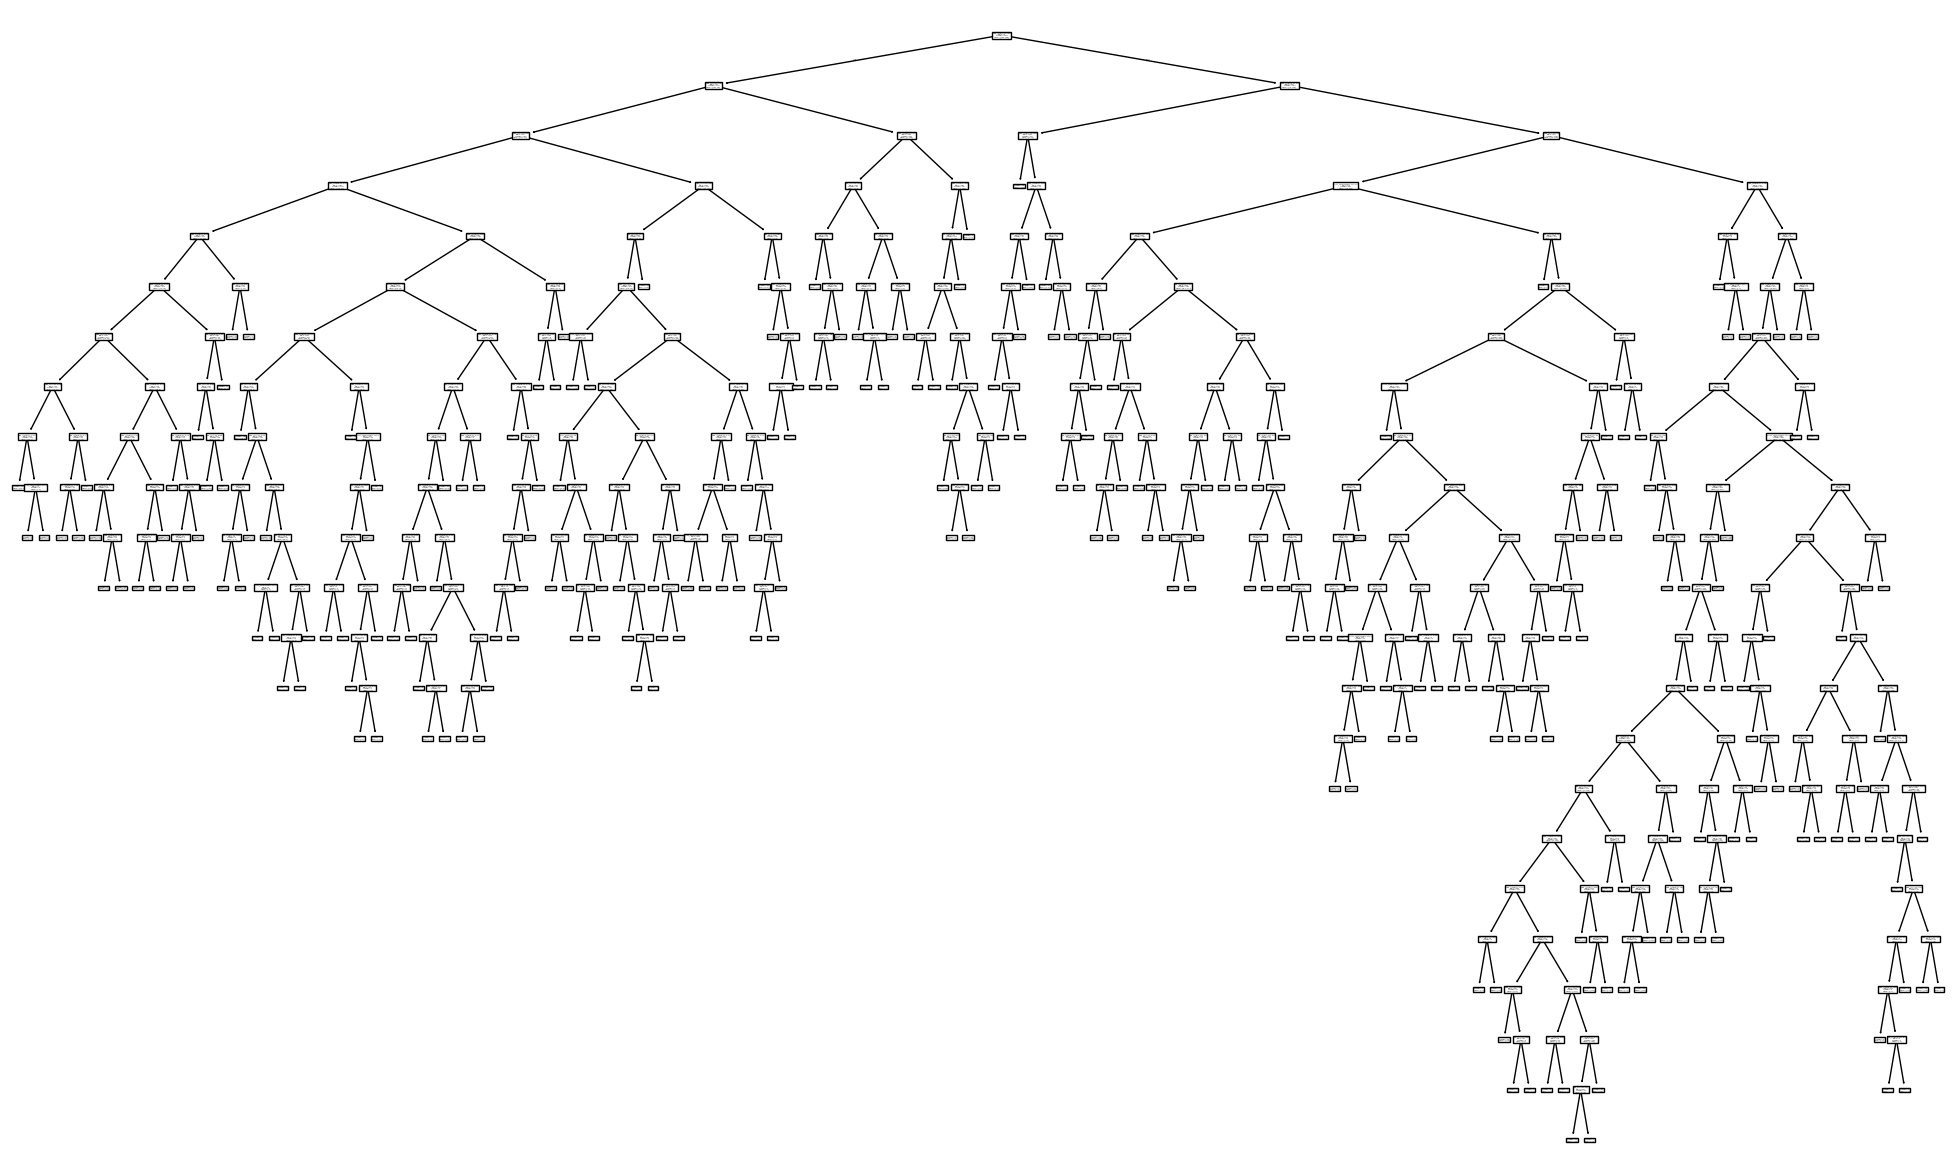

In [54]:
plt.figure(figsize=(25,15))
plot_tree(model_dt, feature_names=list(X_train_selected.columns))
plt.show()

Hyperparameter Tuning Section

In [56]:
# hyperparameter grid
params = {
    'criterion':        ['gini', 'entropy'],
    'max_depth':        [3, 5, 7, 9, 11, None],
    'min_samples_split':[2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
}

# fixed class‐weight to help the tree learn minority class
cw = {0: 1, 1: 20}



# define cost weights
cost_fn = 20
cost_fp = 1

best_cost   = np.inf
best_recall = -1.0
best_params = {}
best_model  = None

print("Tuning hyperparameters to minimize FN/FP cost…")
for criterion in params['criterion']:
    for max_depth in params['max_depth']:
        for min_split in params['min_samples_split']:
            for min_leaf in params['min_samples_leaf']:
                model = DecisionTreeClassifier(
                    criterion=criterion,
                    max_depth=max_depth,
                    min_samples_split=min_split,
                    min_samples_leaf=min_leaf,
                    class_weight= cw,
                    random_state=42
                )
                model.fit(X_train_selected, y_train)
                
                y_val_pred = model.predict(X_val_selected)
                tn, fp, fn, tp = confusion_matrix(y_valid, y_val_pred).ravel()
                
                cost = fn * cost_fn + fp * cost_fp
                rec  = recall_score(y_valid, y_val_pred, pos_label=1)
                
                # progress indicator
                print('.', end='')
                
                # 4) select model with lowest cost, tie‐break by higher recall
                if (cost < best_cost) or (cost == best_cost and rec > best_recall):
                    best_cost   = cost
                    best_recall = rec
                    best_params = {
                        'criterion':         criterion,
                        'max_depth':         max_depth,
                        'min_samples_split': min_split,
                        'min_samples_leaf':  min_leaf,
                        'class_weight':      cw
                    }
                    best_model = model


print("\n\nBest hyperparameters under cost_fn=20, cost_fp=1:")
for name, val in best_params.items():
    print(f"  {name}: {val}")
print(f"Best validation cost: {best_cost:.0f}")
print(f"Corresponding recall: {best_recall:.4f}")

# confusion matrix
y_valid_pred = best_model.predict(X_val_selected)
cm = confusion_matrix(y_valid, y_valid_pred)
print("\nConfusion matrix of best model on validation set:")
print(cm)

print("ROC AUC:", roc_auc_score(y_valid, y_valid_pred))

Tuning hyperparameters to minimize FN/FP cost…
................................................................................................................................................

Best hyperparameters under cost_fn=20, cost_fp=1:
  criterion: gini
  max_depth: 7
  min_samples_split: 2
  min_samples_leaf: 1
  class_weight: {0: 1, 1: 20}
Best validation cost: 134
Corresponding recall: 0.8235

Confusion matrix of best model on validation set:
[[168  74]
 [  3  14]]
ROC AUC: 0.7588721438988819


In [57]:
# 1) Predict with the model
y_pred = best_model.predict(X_test_selected)

# 2) Print metrics
print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

Accuracy on test set:  0.688588007736944
Confusion Matrix:
 [[335 148]
 [ 13  21]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.81       483
           1       0.12      0.62      0.21        34

    accuracy                           0.69       517
   macro avg       0.54      0.66      0.51       517
weighted avg       0.91      0.69      0.77       517

ROC AUC: 0.6556144196809157


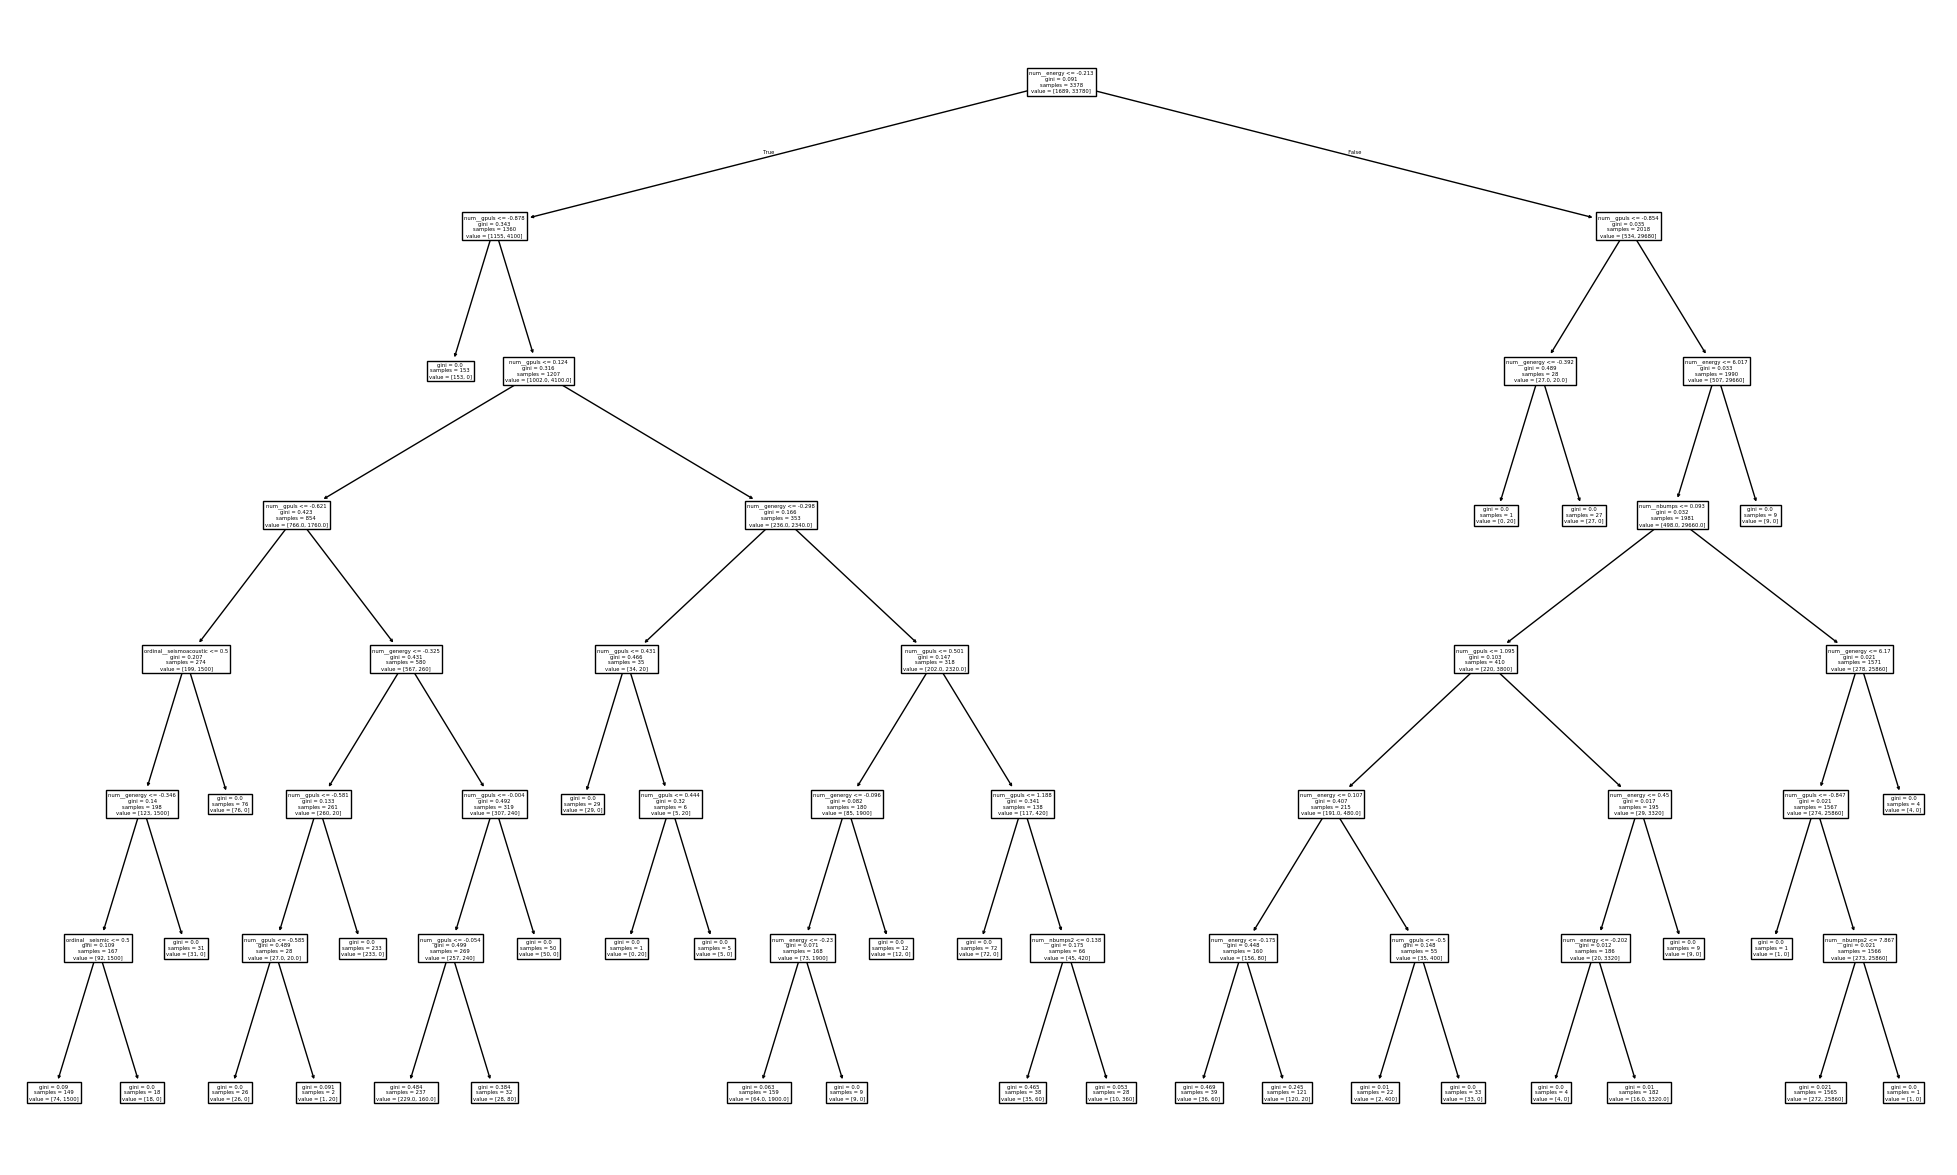

In [58]:
plt.figure(figsize=(25,15))
plot_tree(best_model, feature_names=list(X_train_selected.columns))
plt.show()

### Evaluate the models
Perform a comparison between the predictive models. <br>
Report the accuracy, recall, precision and F1-score measures as well as the confusion matrix if it is a classification problem. <br>
Report the R2 score, mean squared error and mean absolute error if it is a regression problem.
______________________________________________________________________________________
Description: In this case, we **avoid using model accuracy** to evaluate our model as it is imbalance class, simply predicting majority class will yield high accuracy which is not the result we desired to achieve. <br> Thus, we more **focus on metrices like recall and f1 score** to evaluate our model as it tried to strike a balance between **yielding more TN (true bumps report)** while **surpress FN (missing a bumps report) to a minimum** and **maintain a acceptable FP (Fake bumps report)** to a maintanable degree. It is because fake bumps report can be further excluded by human action while having a real bumps report missed is a serious cost.

#### Support Vector Machine (SVM) Performance Evaluation

Best Model : SVC(C=0.1, class_weight='balanced', gamma=10)

Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.77      0.86       483
           1       0.15      0.59      0.24        34

    accuracy                           0.76       517
   macro avg       0.56      0.68      0.55       517
weighted avg       0.91      0.76      0.82       517

Recall (Class 1): 0.5882
Accuracy : 0.7582

Confusion Matrix of SVM: rgb with gamma = 10, C = 0.1
[[372 111]
 [ 14  20]]


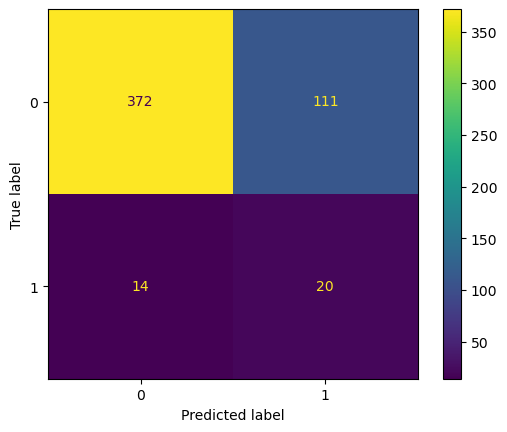

In [61]:
y_pred_svm = last_svc_model.predict(X_test_selected)
recall1_svm_result = recall_score(y_test,y_pred_svm, pos_label=1)
accuracy_svm_result = accuracy_score(y_test,y_pred_svm)

print('Best Model : {}'.format(last_svc_model))
print('\nClassification Report : ')
print(classification_report(y_test,y_pred_svm))

print('Recall (Class 1): {:.4g}'.format(recall1_svm_result))
print('Accuracy : {:.4g}'.format(accuracy_svm_result))
print('\nConfusion Matrix of SVM: rgb with gamma = 10, C = 0.1')
print(confusion_matrix(y_test,y_pred_svm))
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

#### Decision Tree Performance Evaluation

Best Depth of Gini : DecisionTreeClassifier(class_weight={0: 1, 1: 20}, max_depth=7, random_state=42)

Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.69      0.81       483
           1       0.12      0.62      0.21        34

    accuracy                           0.69       517
   macro avg       0.54      0.66      0.51       517
weighted avg       0.91      0.69      0.77       517

Recall (Class 1): 0.6176
Accuracy : 0.6886

Confusion Matrix of Decision Tree: Gini
[[335 148]
 [ 13  21]]


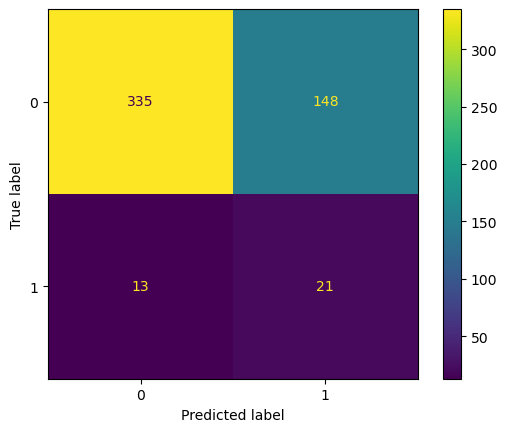

In [63]:
y_pred_dt = best_model.predict(X_test_selected)
recall1_dt_result = recall_score(y_test,y_pred_dt, pos_label=1)
accuracy_dt_result = accuracy_score(y_test,y_pred_dt)

print('Best Depth of Gini : {}'.format(best_model))
print('\nClassification Report : ')
print(classification_report(y_test,y_pred_dt))

print('Recall (Class 1): {:.4g}'.format(recall1_dt_result))
print('Accuracy : {:.4g}'.format(accuracy_dt_result))
print('\nConfusion Matrix of Decision Tree: Gini')
print(confusion_matrix(y_test,y_pred_dt))
cm = confusion_matrix(y_test, y_pred_dt, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

#### Comparison between SVM and Decision Tree:



##### Confusion Matrix

SVM:
 <br>[[372 111]
 <br>[ 14  20]]

Decision Tree:
<br> [[335 148]
<br>[ 13  21]]

**For Class 0 (non-hazard)**:
The SVM model correctly classified more instances compared to the Decision Tree model . However, the SVM model also misclassified more instances  as Class 1 (hazard) compared to Decision Tree model.

**For Class 1 (hazard)**:
The Decision Tree model correctly classified more instances compared to the SVM model. Decision Tree model also has more misclassification of instances as Class 0 (non-hazard) compared to SVM model .

For seismic hazard detection, where the primary goal is identifying potential seismic hazards, the priority is given to the Class 1 (hazard) identification. Thus, the Decision Tree model performs better as it correctly classified more Class 1 instances with low misclassification.

##### Recall 

**For Class 0 (non-hazard)**:
<br>The SVM model has higher recall compared to Decision Tree model. 

**For Class 1 (hazard)**:
<br>The Decision Tree model has higher recall compared to SVM model. 

As misclassification of Class 1 (hazard) is critical in detecting seismic hazard, the recall for Class 1 is prioritised. In this scenario, the performance of Decision Tree model is better, as it ensures that minimum seismic hazard is missed (minimum false negatives). 

##### F1-Score

**For Class 0 (non-hazard)**:
<br>The SVM model has higher F1-score compared to Decision Tree model. 

**For Class 1 (hazard)**:
<br>The SVM model has higher F1-score compared to Decision Tree model.



##### Accuracy

The Decision Tree model has higher accuracy than the SVM model. 

##### Conclusion
In the context of seismic hazard detection, where the primary concern is identifying potential seismic hazards (Class 1), the Decision Tree model demonstrates better performance due to its **higher recall for Class 1**, ensuring fewer hazard cases are missed. This is particularly important in risk-sensitive applications such as disaster prevention. Although the SVM model misclassifies fewer non-hazard instances as hazard (fewer false positives), it also fails to identify more actual hazard cases (higher false negatives), which is critical.

If minimizing missed hazard cases is the top priority (as is often the case in early warning systems), the Decision Tree model is preferred. However, if reducing false alarms (false positives) is more important in a specific context (e.g., limited response resources), SVM might be considered. Nevertheless, this comes at the cost of missing some actual hazards.

Ultimately, for applications where missing seismic hazards is unacceptable, the **Decision Tree model** is more suitable due to its superior recall for Class 1.